# Machine Learning - Recommendation System example

Modified from https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/machine_learning/example_recommendation.ipynb

### 0 - Setup

###### Import pckgs

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

###### Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
NY_reviews = pd.read_csv('/content/drive/MyDrive/DS4A Team4/New_York_reviews_cleaned.csv', index_col=0)
NY_reviews.head()

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
1,Lido,5,Positive,a regular treat,my wife and i have been eating dinner frequent...,my wife and i have been eating dinner frequent...,2020-10-08,UID_0
2,Lido,4,Positive,good neighborhood spot!,came with family for labor day weekend brunch ...,came with family for labor day weekend brunch ...,2020-09-08,UID_1
3,Lido,1,Negative,disappointing,food was mediocre at best. the lamb chops are...,food was mediocre at best. the lamb chops are ...,2020-02-17,UID_2
4,Lido,5,Positive,what a find in harlem,my co-workers were volunteering at a foodbank ...,my co-workers were volunteering at a foodbank ...,2019-11-25,UID_3
5,Lido,5,Positive,lunch,lido is an intimate boutique style restaurant....,lido is an intimate boutique style restaurant....,2019-11-23,UID_4


In [4]:
#check and aggregate the multiple reviews by one author for a single restaurant
grouped = NY_reviews.groupby(['author_id', 'restaurant_name'])

review_counts = grouped.size().reset_index(name='review_count')

review_avg = grouped['rating_review'].mean().reset_index(name='review_avg')

review_counts['avg_rating'] = review_avg['review_avg']

multi_review_list = review_counts.sort_values(by='review_count', ascending=False)

print(multi_review_list[multi_review_list['review_count']>1])

         author_id         restaurant_name  review_count  avg_rating
17592    UID_10761             Ess_a_Bagel            11    5.000000
338941     UID_438            P_J_Clarke_s            10    4.600000
437325   UID_76880           Comfort_Diner            10    5.000000
476335   UID_91316    Da_Marino_Restaurant            10    5.000000
247630   UID_23231    Wonton_Noodle_Garden             9    4.222222
...            ...                     ...           ...         ...
63299   UID_127903                Treehaus             2    3.000000
247799  UID_232443            Bodega_Negra             2    5.000000
129546  UID_161229     Blue_Smoke_Flatiron             2    5.000000
317091   UID_37510    Le_CouCou_Restaurant             2    5.000000
120422  UID_156355  John_s_of_Times_Square             2    5.000000

[11139 rows x 4 columns]


### 1 - Data Analysis

In [5]:
dtf_users = multi_review_list.pivot(index = 'author_id', columns = 'restaurant_name', values = 'avg_rating')
restaurant_names = dtf_users.columns
user_names = dtf_users.index

In [6]:
restaurant_names

Index(['12_Chairs', '16_Handles', '1902_Empire_Iii_Inc', '1_Chimi_Sushi',
       '211_New_Taco_Grill', '212_Restaurant_And_Bar', '21_Club', '230_Fifth',
       '2_Bros_Pizza', '2nd_Avenue_Deli',
       ...
       'Zadies', 'Zen_Ramen_Sushi', 'Zero_Otto_Nove', 'Zest_Ramen',
       'Zheng_s_Lucky_Sunday_Garden', 'Zio_Ristorante',
       'Zoe_Restaurant_Lounge', 'Zoni_Cafe',
       'Zoob_Zib_Thai_Authentic_Noodle_Bar', 'Zuma'],
      dtype='object', name='restaurant_name', length=1805)

In [9]:
user_names

Index(['UID_0', 'UID_1', 'UID_10', 'UID_100', 'UID_1000', 'UID_10000',
       'UID_100000', 'UID_100001', 'UID_100002', 'UID_100003',
       ...
       'UID_99990', 'UID_99991', 'UID_99992', 'UID_99993', 'UID_99994',
       'UID_99995', 'UID_99996', 'UID_99997', 'UID_99998', 'UID_99999'],
      dtype='object', name='author_id', length=249901)

In [7]:
dtf_users.columns = range(0,len(dtf_users.columns))

In [8]:
dtf_users.index = range(0,len(dtf_users.index))

###### Context

### 2 - Preprocessing

- Scaling
- Partitioning

###### Scaling

In [9]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values),
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

,0,1,2,3,4,5,6,7,8,9,...,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Partitioning

In [10]:
split = int(0.8*dtf_users.shape[1])
split

1444

In [11]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 397849


,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 99614


,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,...,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5 - Model Desing & Testing (Neural Collaborative Filtering)

###### Data

In [14]:
train1 = dtf_train.loc[:,:split/4-1].stack(dropna=True).reset_index().rename(columns={0:"y"})

In [15]:
train2 = dtf_train.loc[:,split/4:split/2-1].stack(dropna=True).reset_index().rename(columns={0:"y"})

In [16]:
train3 = dtf_train.loc[:,split/2:split*3/4-1].stack(dropna=True).reset_index().rename(columns={0:"y"})

In [17]:
train4 = dtf_train.loc[:,split*3/4:].stack(dropna=True).reset_index().rename(columns={0:"y"})

In [27]:
train = pd.concat([train1,train2,train3,train4])
train.columns = ["user","product","y"]
train.head()

,user,product,y
0,2,162,0.875
1,8,25,0.875
2,8,247,0.875
3,9,25,0.875
4,10,25,1.000


In [26]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.columns = ["user","product","y"]
test.head()

,user,product,y
0,4,1611,0.875
1,16,1652,0.500
2,16,1689,0.875
3,16,1706,1.000
4,16,1747,1.000


###### Model Design

In [29]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        12495050    ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        90250       ['xproducts_in[0][0]']           
                                                                      

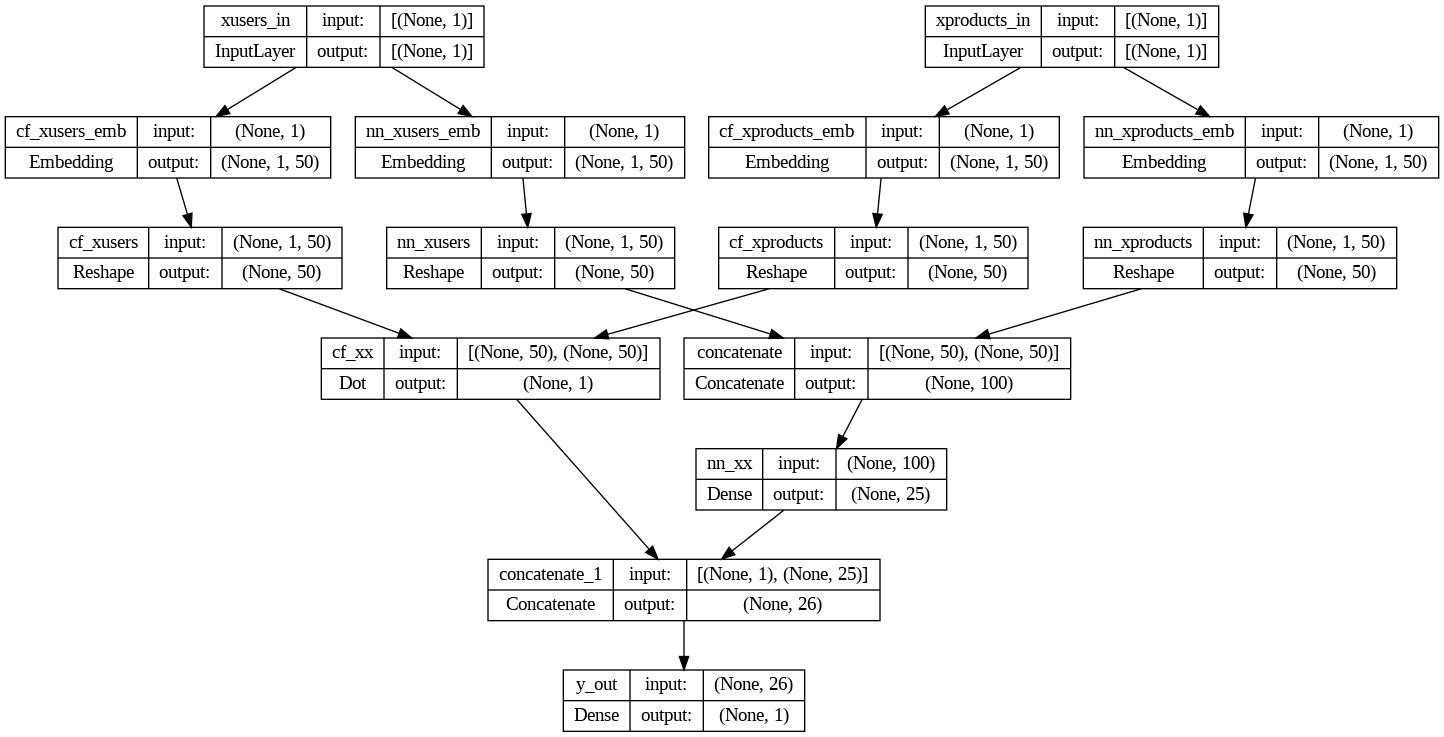

In [30]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

###### Train / Test

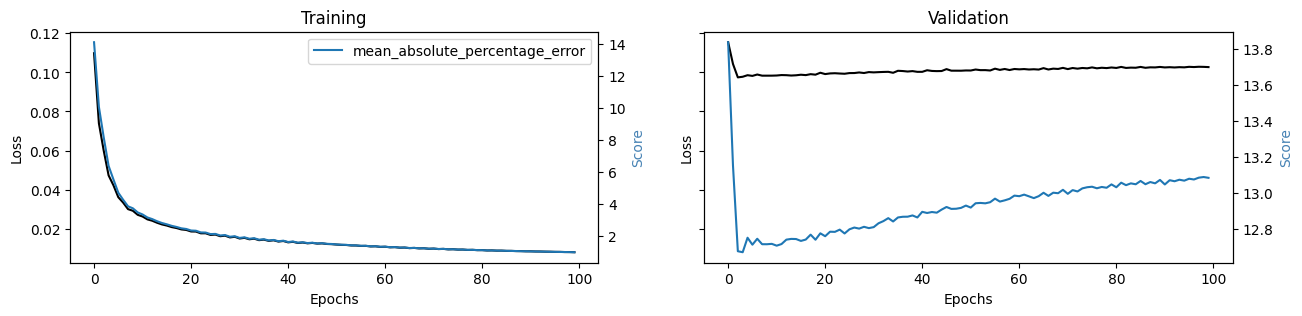

In [31]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [32]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

3113/3113 [==============================] - 7s 2ms/step


,user,product,y,yhat
0,4,1611,0.875,0.925758
1,16,1652,0.500,0.950223
2,16,1689,0.875,0.865727
3,16,1706,1.000,0.956675
4,16,1747,1.000,0.936646
...,...,...,...,...
99609,249887,1497,0.875,0.936742
99610,249888,1716,0.875,0.857326
99611,249889,1716,1.000,0.955021
99612,249891,1716,1.000,0.989278


###### Evaluate

In [33]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.11%


In [35]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [38]:
# single case
i = 16
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 16 ---
y_test: [1706 1747 1689 1652]
predicted: [1706 1652 1747 1689]
true positive: 4 (80.0%)
accuracy: 25.0%
mrr: 0.52


In [41]:
user_names[16]

'UID_10001'